In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import matplotlib

In [2]:
import os
if not os.path.exists('figures'):
    os.makedirs('figures')

# Hyperparameters and Model Validation

In th eprevious section, we saw the basic recipe fr aplying a supervised machine learning model:

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to tghe training data
4. Use th emodel to predict labels for new data

The first two pieces of this - the choice of model and choice of hyperparameters - are perhaps the most important part of using these tools and techniques effectively. In order to make an informed choice, we need a way to **validate** that our model and our hyperparameters are a good fit to the data. While this may sound simple, there are some pitfalls thta you must avoid to do this effectively.

## Thinking About Model Validation

In principle, model validation is very simple: after choosing a model and its hyperparameters, we can estimate how effective it is by applying it to some of the training data and comparing the prediction to the known value. 

The following sections first show a naive approach to model validation and why it fails, before exploring the use of holdout sets and cross-validation for more robust model evaluation.


### Model validation the wrong way

Let's deminstrate the noive approach to validation using the Iris data, which we saw in the previous section. We will start by loading the data:

In [3]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

Next we choose a model and hyperparameters. Here we'll use a k-neighbors classifier with `n_neighbors=1`. This is a very simple and intuitive model that says "the label of an unknown point is the same as the label of its closest training points":

In [4]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

Then we train the model, and use it to predict labels for data we already know:

In [5]:
model.fit(X,y)
y_model = model.predict(X)

Finally, we compute the fraction of correctly labeled points:

In [6]:
from sklearn.metrics import accuracy_score
accuracy_score(y,y_model)

1.0

We see an accuracy score of 1.0, which indicates that 100% of points were correctly labeled by our model! But is this truly measureing the expected accuracy? Have we really come upon a model that we excpet to be correct 100% of the time?

As you may have gathered, the answer is no. In fact, this approach contains a fundamental flaw: **it trains and evaluates the model on the same data**. Furthermore, the nearest neighbor model is an **instance-based** estimator that simply stores the training data, and predicts labels by comparing new data to these stored points; except in contrived cases, it will get 100% accuracy **every time!**

### Model validation the right way: Holdout sets

So what can be done? We can get a better sense of a model's performance using what's known as a **holdout set**; that is, we hold back some subset of the data from the training of the model, and then use this holdout set to check the model performance. We can do this splitting using the `train_test_split` utility in Scikit-Learn:

In [7]:
from sklearn.model_selection import train_test_split
# split the data with 50% in each set
X1, X2, y1, y2 = train_test_split(X,y,random_state=0,
                                 train_size=0.5)

# fir the model on one set of data
model.fit(X1,y1)

# evaluate the model on the second set of data
y2_model = model.predict(X2)
accuracy_score(y2,y2_model)

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9066666666666666

We see here a more resonable result: the nearest0neighbor classifier is about 90% accurate on this holdout set. The holdout set is similar to unknown data, beacsue the model has not "seen" it before.

### Model validation via cross-validation

One disadvantage of using a holdout set for model validation is that we have lost a portion of our data to the model training. In the previous case, half the dataset does not contribute to the training of the model! This is not optimal, and can cause problems - espacially if the initial set of training data is small.

One way to address this is to use **cross-validation** - that is, to do a sequance of fits where each subset of the data is used both as a training set and as a validation set. Visually, it might look something like in the next figure.

In [8]:
def draw_rects(N, ax, textprop={}):
    for i in range(N):
        ax.add_patch(plt.Rectangle((0, i), 5, 0.7, fc='white'))
        ax.add_patch(plt.Rectangle((5. * i / N, i), 5. / N, 0.7, fc='lightgray'))
        ax.text(5. * (i + 0.5) / N, i + 0.35,
                "validation\nset", ha='center', va='center', **textprop)
        ax.text(0, i + 0.35, "trial {0}".format(N - i),
                ha='right', va='center', rotation=90, **textprop)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-0.2, N + 0.2)

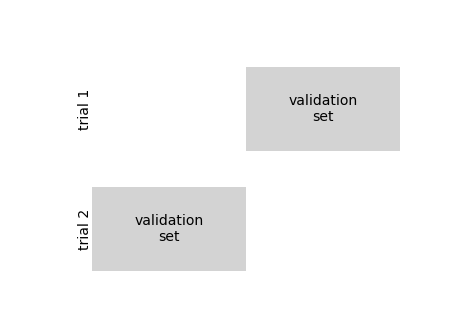

In [9]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(2, ax, textprop=dict(size=14))

fig.savefig('figures/05.03-2-fold-CV.png')

Here we do two validation trails, alternatively using each half of the data as a holdout set. Using the slpit data from before, we could implement it like this:

In [10]:
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)
accuracy_score(y1,y1_model), accuracy_score(y2,y2_model)

(0.96, 0.9066666666666666)

What comes out are two accuray scores, which we could combine (by, say, taking the mean) to get a better measure of the global model performance. This particular form of cross-validation is a **two-fold cross-validation** - one in which we have split the data into two sets and used each in turn as a validation set.

we could expand on this idea to use even more trials, and more folds in the data - for example, the next figure is a visual depiction of five-fold cross-validation.

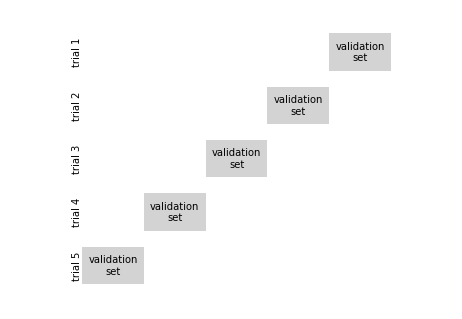

In [11]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
draw_rects(5, ax, textprop=dict(size=10))

fig.savefig('figures/05.03-5-fold-CV.png')

Here we split the data into five groups, and use each of them in turn to evaluate the model fit on the other 4/5 of the data. This would be rather tedious to do by hand, and so we can use Scikit-Learn's `cross_val_score` convenience routine to do it succincly:

In [12]:
from sklearn.model_selection import cross_val_score
cross_val_score(model,X,y,cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

Repeating the validation across different subsets of the data gives us an even better idea of the performance of the algorithm.

Scikit-LEARN implements a number of cross-validation schemes that are useful in particular suituations; these are implemented via iterators in the `cross_validation` (actually: `model_selection`) module. For example, we might with to go to the extreme case in which our number of folds is equal to the number of data points; that is, we train on all points but one in each trail. This type of cross-validation is known as **leave-one-out** cross-validation, and can be used as follows:

In [14]:
# from sklearn.model_selection import LeaveOneOut
# scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
# scores

Because we have 150 samples, the leave-one-out cross-validation yields scores for 150 trials, and the score indicates either successful (1.0) or unsuccessful (0.0) predction. Taking th emans of these gives an estimate of the error rate:

In [15]:
# scores.mean()

Other cross-validation schemes can be used similarly. For a description of what is available in Scikit-Learn, use IPython to explore the `sklearn.cross_validation` (actually `model_selection`) submodule, or take a look at Scikit-Learn'd online cross-validation documentation (http://scikit-learn.org/stable/moldules/cross_validation.htlm).

## Selecting the Best Model

Now that we've seen the basics of validation and cross-validation, we'll go into a little more depth regarding model selector and selection of hyperparameters. These issues are some of the most important aspects of the practice of machine learning, and I find that this information is often glossed over in introductory machine learning tutorials.

Of core importance is the following question: **if our estimator is underperforming, how should we move forward?** There are several possible answers:

- Use a more complicated / more flexible model
- Use a less complicated / less flexible model
- Gather more training samples
- Gather more data to add features to each sample

The answer to this question is often counterintuitive. In particular, sometimes using a more complicated model will give worse results, and adding more traing samples may not improve your result! The ability to determine what step will improve your model is what separates the successful machine learning practitioners from the unsuccessful.

### The bias-variance trade-off

Fundamentally, the question of **best model** is about finding a sweet spot in the trade-off between **bias** and **variance**. Consider the next firgure, which presents two regressions fits to the same dataset.

In [17]:
import numpy as np

def make_data(N=30, err=0.8, rseed=1):
    # randomly sample the data
    rng = np.random.RandomState(rseed)
    X = rng.rand(N, 1) ** 2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y

In [18]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                         LinearRegression(**kwargs))

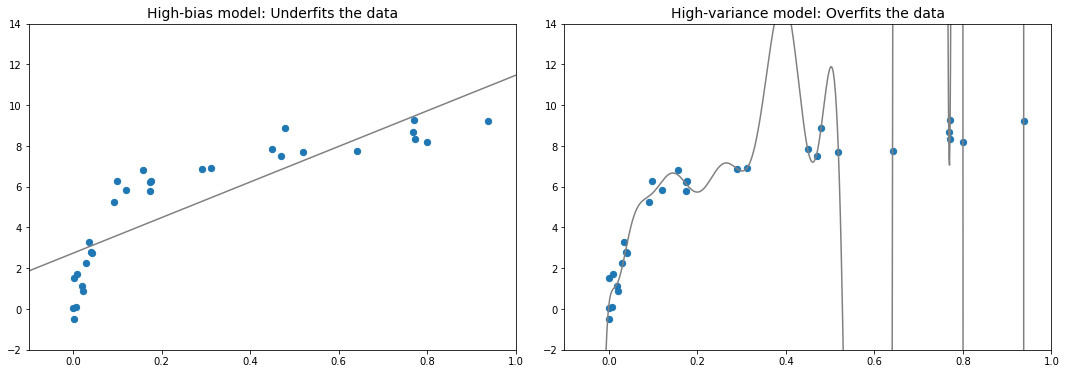

In [19]:
X, y = make_data()
xfit = np.linspace(-0.1, 1.0, 1000)[:, None]
model1 = PolynomialRegression(1).fit(X, y)
model20 = PolynomialRegression(20).fit(X, y)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

ax[0].scatter(X.ravel(), y, s=40)
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)

ax[1].scatter(X.ravel(), y, s=40)
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)

fig.savefig('figures/05.03-bias-variance.png')

It is clear that neither of these models ia a particular good fit to the data, but they fail in different ways.

The model on the left attempts to find a straight-line fit through the data. Because the data are intrinsically more complicated than an straight line, the straight-line model will never be able to describe this dataset well. Such a model is said to **underfit** the data; that is, it does not have enough model flexibility to suitably account for all the features in the data. Another way of saying this is that the model has high **bias**.

The model on the right attempts to fit a high-order polynominal through the data. Here the model fit has enough flexibility to nearly perfectly account for the fine features in the data, but even though it very accurately describes the training data, its precise form seems to be  more reflective of the particular noise properties of the data rather than the intrinsic properties of whatever process generated that data. Such a model is said to **overfit** the data; that is, it has so much model flexibility that the model ends up accounting for random errors as well as the underlying data distribution. Another way of saying this is that the model has high **variance**.

To look at this in another light, consider what happens if we use two models to predict the y-value for some new data. In the diagram in the next figure, the red/lighter points indicate data that is omitted from the training set.

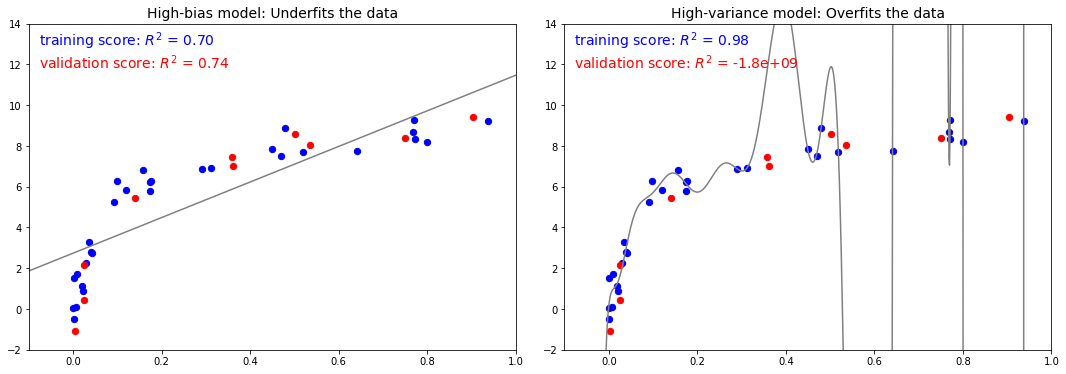

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X2, y2 = make_data(10, rseed=42)

ax[0].scatter(X.ravel(), y, s=40, c='blue')
ax[0].plot(xfit.ravel(), model1.predict(xfit), color='gray')
ax[0].axis([-0.1, 1.0, -2, 14])
ax[0].set_title('High-bias model: Underfits the data', size=14)
ax[0].scatter(X2.ravel(), y2, s=40, c='red')
ax[0].text(0.02, 0.98, "training score: $R^2$ = {0:.2f}".format(model1.score(X, y)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='blue')
ax[0].text(0.02, 0.91, "validation score: $R^2$ = {0:.2f}".format(model1.score(X2, y2)),
           ha='left', va='top', transform=ax[0].transAxes, size=14, color='red')

ax[1].scatter(X.ravel(), y, s=40, c='blue')
ax[1].plot(xfit.ravel(), model20.predict(xfit), color='gray')
ax[1].axis([-0.1, 1.0, -2, 14])
ax[1].set_title('High-variance model: Overfits the data', size=14)
ax[1].scatter(X2.ravel(), y2, s=40, c='red')
ax[1].text(0.02, 0.98, "training score: $R^2$ = {0:.2g}".format(model20.score(X, y)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='blue')
ax[1].text(0.02, 0.91, "validation score: $R^2$ = {0:.2g}".format(model20.score(X2, y2)),
           ha='left', va='top', transform=ax[1].transAxes, size=14, color='red')

fig.savefig('figures/05.03-bias-variance-2.png')

The scroe here is the `R^2` score, or coefficient of determination, which measures how well a model performs relative to a simple mean of the target values. R^2 = 1 indicates a perfect match, R^2 = 0 indicates the model does no better than simply taken the mean of the data, and negative values mean even worse models. Form the scores associated with these two models, we can make an observation that holds more generally:

- For high-bias models (underfit), the performance of the model on the validation set is similar to the performance on the training set.
- For high-variance models (overfit), the performance of the model on the validation set is far worse than the performance on the training set.

If we image that we have some ability to tune the model complexity, we would expect the training score and validation score to behave as illustrated in the next figure:

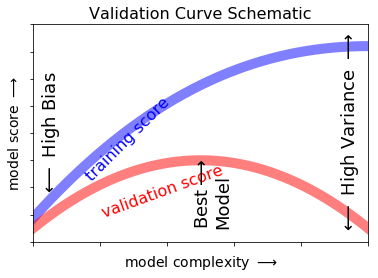

In [23]:
x = np.linspace(0, 1, 1000)
y1 = -(x - 0.5) ** 2
y2 = y1 - 0.33 + np.exp(x - 1)

fig, ax = plt.subplots()
ax.plot(x, y2, lw=10, alpha=0.5, color='blue')
ax.plot(x, y1, lw=10, alpha=0.5, color='red')

ax.text(0.15, 0.2, "training score", rotation=45, size=16, color='blue')
ax.text(0.2, -0.05, "validation score", rotation=20, size=16, color='red')

ax.text(0.02, 0.1, r'$\longleftarrow$ High Bias', size=18, rotation=90, va='center')
ax.text(0.98, 0.1, r'$\longleftarrow$ High Variance $\longrightarrow$', size=18, rotation=90, ha='right', va='center')
ax.text(0.48, -0.12, 'Best$\\longrightarrow$\nModel', size=18, rotation=90, va='center')

ax.set_xlim(0, 1)
ax.set_ylim(-0.3, 0.5)

ax.set_xlabel(r'model complexity $\longrightarrow$', size=14)
ax.set_ylabel(r'model score $\longrightarrow$', size=14)

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())

ax.set_title("Validation Curve Schematic", size=16)

fig.savefig('figures/05.03-validation-curve.png')

The diagram shown in  this figure is often called a **validation curve**, and we see the following essential features:

- The training score is everywhere higher than the validation score. This is generally the case: the model will be a better fit to data it has seen than to data it has not seen.
- For very low model complexity (a high-bias model), the training data is underfit, which means that the model is a poor predictor both for the training data and for any previouly unseen data. 
- For very high model complexity (a high-variance model), the training data is overfit, which means that the model predicts the training data very well, but fails for any previously unseen data.
- For some intermediate value, the validation curve has a maximum. Ths level of complexity indicates a suitable trade-off between bias and variance.

The means of tuning the model complexity varies from model to model; when we discuss individual models in depth in later sections, we will see how each model allows for such tuning.

### Validation curves in Scikit-Learn

Let's look at an example of using cross-validation to compute the validation curve for a class of models. Here we will use a **polynominal regression** model: this is a generalized linear model in which the degree of the polynominal is a tunable parameter. For example, a degree-1 polynominal fits s straight line to the data; for model parameters a and b:

\begin{equation}
y = a x + b
\end{equation}

A degree-3 polynominal fits a cubic curve to the data; for model parameters a, b, c, d:

\begin{equation}
y = a x^3 + b x^2 + c x + d
\end{equation}

We can generalize this to any number of polynominal features. In Scikit-Learn, we can implement this with a simple linear regression combined with the polynimonial pre-processor. 

## Learning Curves

## Validation in Practice: Grid Search

## Summary